<img src="https://github.com/retkowsky/visual-search-azureAI/blob/main/logo.jpg?raw=true">

# Fashion Visual Search demo

## 2. Azure Cognitive Search Vector Search with Azure Computer Vision 4 (Florence)

This code demonstrates how to use **Azure Cognitive Search** with **Cognitive Services Florence Vision API** and Azure Python SDK for visual search.


## Steps
- Connect to a blob storage where your catalog images are
- Use Azure Computer Vision 4 to embed all these images
- Create an Azure Cognitive search vector store index
- Upload the embeddings into an Azure Cognitive Search index
- Do some visual search using a prompt or an image


## Visual search with vector embeddings
Vector embeddings are a way of representing content such as text or images as vectors of real numbers in a high-dimensional space. These embeddings are often learned from large amounts of textual and visual data using machine learning algorithms like neural networks. Each dimension of the vector corresponds to a different feature or attribute of the content, such as its semantic meaning, syntactic role, or context in which it commonly appears. By representing content as vectors, we can perform mathematical operations on them to compare their similarity or use them as inputs to machine learning models.

## Process
<img src="https://raw.githubusercontent.com/retkowsky/Azure-Computer-Vision-in-a-day-workshop/72c07afc4fcc04a29ca19b84d3d343a09a22368e//fashionprocess.png" width=512>

## Business applications
- Digital asset management: Image retrieval can be used to manage large collections of digital images, such as in museums, archives, or online galleries. Users can search for images based on visual features and retrieve the images that match their criteria.
- Medical image retrieval: Image retrieval can be used in medical imaging to search for images based on their diagnostic features or disease patterns. This can help doctors or researchers to identify similar cases or track disease progression.
- Security and surveillance: Image retrieval can be used in security and surveillance systems to search for images based on specific features or patterns, such as in, people & object tracking, or threat detection.
- Forensic image retrieval: Image retrieval can be used in forensic investigations to search for images based on their visual content or metadata, such as in cases of cyber-crime.
- E-commerce: Image retrieval can be used in online shopping applications to search for similar products based on their features or descriptions or provide recommendations based on previous purchases.
- Fashion and design: Image retrieval can be used in fashion and design to search for images based on their visual features, such as color, pattern, or texture. This can help designers or retailers to identify similar products or trends.

## To learn more
- https://learn.microsoft.com/en-us/azure/cognitive-services/computer-vision/concept-image-retrieval
- https://learn.microsoft.com/en-us/azure/search/search-what-is-azure-search

In this notebook we took some samples fashion images are taken from this link:<br>
https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-dataset

> Note: Image retrieval is curently in public preview

In [1]:
# %pip install --index-url=https://pkgs.dev.azure.com/azure-sdk/public/_packaging/azure-sdk-for-python/pypi/simple/ azure-search-documents==11.4.0a20230509004

## 1. Python librairies

In [2]:
import datetime
import io
import json
import math
import os
import requests
import sys
import time

from dotenv import load_dotenv
from io import BytesIO
from PIL import Image

from azure.core.credentials import AzureKeyCredential
from azure.search.documents import SearchClient
from azure.search.documents.indexes import SearchIndexClient
from azure.search.documents.indexes import SearchIndexerClient
from azure.search.documents.indexes.models import (
    PrioritizedFields,
    SearchableField,
    SearchField,
    SearchFieldDataType,
    SearchIndex,
    SearchIndexerDataContainer,
    SearchIndexerDataSourceConnection,
    SemanticConfiguration,
    SemanticField,
    SemanticSettings,
    SimpleField,
    VectorSearch,
    VectorSearchAlgorithmConfiguration,
)
from azure.storage.blob import BlobServiceClient

In [3]:
sys.version

'3.8.5 (default, Sep  4 2020, 07:30:14) \n[GCC 7.3.0]'

In [4]:
print("Today is", datetime.datetime.today())

Today is 2023-06-30 10:08:46.786003


## 2. Azure AI Services

In [5]:
load_dotenv("azure.env")

# Azure Computer Vision 4
acv_key = os.getenv("acv_key")
acv_endpoint = os.getenv("acv_endpoint")

# Azure Cognitive Search
acs_endpoint = os.getenv("acs_endpoint")
acs_key = os.getenv("acs_key")

# Azure storage account
blob_connection_string = os.getenv("blob_connection_string")
container_name = os.getenv("container_name")

In [6]:
# Ensure that the azure endpoints should not finished a /
if acv_endpoint.endswith("/"):
    acv_endpoint = acv_endpoint[:-1]

if acs_endpoint.endswith("/"):
    acs_endpoint = acv_endpoint[:-1]

In [7]:
# Azure Cognitive Search index name to create
index_name = "azure-fashion-demo"

# Azure Cognitive Search api version
api_version = "2023-02-01-preview"

## 3. Connect to Blob Storage

Retrieve your images from Blob Storage.
All the fashion images are in one blob storage.

In [8]:
# Connect to Blob Storage
blob_service_client = BlobServiceClient.from_connection_string(blob_connection_string)
container_client = blob_service_client.get_container_client(container_name)
blobs = container_client.list_blobs()

first_blob = next(blobs)
blob_url = container_client.get_blob_client(first_blob).url
print(f"URL of the first blob: {blob_url}")

URL of the first blob: https://azurestorageaccountsr.blob.core.windows.net/fashionimages/fashion/0390469004.jpg


## 4. Connect your Blob Storage to a data source in Azure Cognitive Search

In [9]:
# Create a data source
ds_client = SearchIndexerClient(acs_endpoint, AzureKeyCredential(acs_key))
container = SearchIndexerDataContainer(name=container_name)
data_source_connection = SearchIndexerDataSourceConnection(
    name=f"{index_name}-blob",
    type="azureblob",
    connection_string=blob_connection_string,
    container=container,
)
data_source = ds_client.create_or_update_data_source_connection(data_source_connection)

print(f"Done. Data source '{data_source.name}' has been created or updated.")

Done. Data source 'azure-fashion-demo-blob' has been created or updated.


## 5. Our fashion images

In [10]:
blob_service_client = BlobServiceClient.from_connection_string(blob_connection_string)
container_client = blob_service_client.get_container_client(container_name)
number_images = len(list(container_client.list_blobs()))

print("Total number of images =", number_images, "in blob:", container_name)

Total number of images = 10226 in blob: fashionimages


In [11]:
def describe_image(image_file):
    """
    Get tags & caption from an image using Azure Computer Vision 4 Florence
    """
    options = "&features=tags,caption"
    model = "?api-version=" + api_version + "&modelVersion=latest"
    url = acv_endpoint + "/computervision/imageanalysis:analyze" + model + options

    headers_cv = {
        "Content-type": "application/octet-stream",
        "Ocp-Apim-Subscription-Key": acv_key,
    }

    blob_client = container_client.get_blob_client(image_file)
    blob_image = blob_client.download_blob().readall()

    # Create an in-memory stream
    image_stream = io.BytesIO(blob_image)
    image = Image.open(image_stream)

    # Convert the image to bytes
    image_bytes = io.BytesIO()
    image.save(image_bytes, format="JPEG")
    image_bytes.seek(0)

    response = requests.post(url, data=image_bytes, headers=headers_cv)

    if response.status_code == 200:
        results = response.json()
        print("Automatic analysis of the image using Azure Computer Vision 4.0:")
        print("\033[1;31;34m")
        print("Main caption:")
        caption = results["captionResult"]["text"]
        confidence = results["captionResult"]["confidence"]
        print(f"{caption} = {confidence:.3f}")

        print("\033[1;31;32m")
        print("Detected tags:")
        tags = results["tagsResult"]["values"]

        for tag in tags:
            name = tag["name"]
            confidence = tag["confidence"]
            print(f"{name} = {confidence:.3f}")

    else:
        print(f"Error: {response.status_code} - {response.text}")
        return None

In [12]:
def view_image(image_file):
    """
    View image from a blob storage
    """
    blob_client = container_client.get_blob_client(image_file)
    blob_image = container_client.get_blob_client(image_file).download_blob().readall()

    # Create an in-memory stream
    image_stream = io.BytesIO(blob_image)

    # Open and display the image
    print("Image:", image_file)
    image = Image.open(image_stream)
    image.thumbnail((640, 640), Image.LANCZOS)
    display(image)

### Some images analysis

Image: fashion/0395658034.jpg


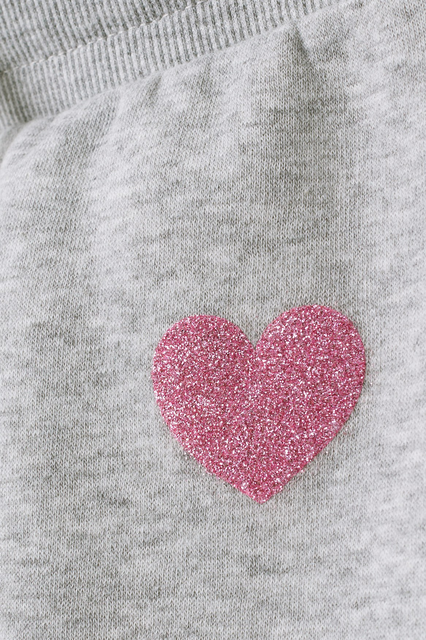

Automatic analysis of the image using Azure Computer Vision 4.0:

Main caption:
a pink heart on a grey sweater = 0.454

Detected tags:
stitch = 0.923
heart = 0.863
needlework = 0.857
fabric = 0.729


In [13]:
image_file = "fashion/0395658034.jpg"

view_image(image_file)
describe_image(image_file)

Image: fashion/0625870004.jpg


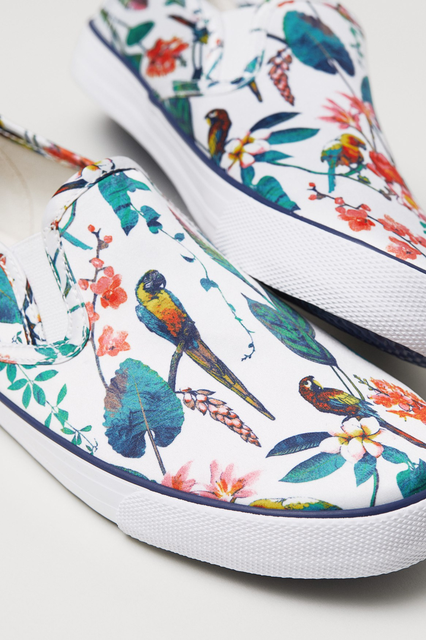

Automatic analysis of the image using Azure Computer Vision 4.0:

Main caption:
a pair of white slip on shoes with birds on them = 0.489

Detected tags:
clothing = 0.962
footwear = 0.951
shoe = 0.867
shoes = 0.640


In [14]:
image_file = "fashion/0625870004.jpg"

view_image(image_file)
describe_image(image_file)

## 6. Azure Computer Vision 4 Florence embeddings functions

<img src="https://learn.microsoft.com/en-us/azure/cognitive-services/computer-vision/media/image-retrieval.png">

### Text Embedding

In [15]:
def text_embedding(prompt):
    """
    Text embedding using Azure Computer Vision 4.0
    """
    version = "?api-version=" + api_version + "&modelVersion=latest"
    vec_txt_url = f"{acv_endpoint}/computervision/retrieval:vectorizeText{version}"
    headers = {"Content-type": "application/json", "Ocp-Apim-Subscription-Key": acv_key}

    payload = {"text": prompt}
    response = requests.post(vec_txt_url, json=payload, headers=headers)

    if response.status_code == 200:
        text_emb = response.json().get("vector")
        return text_emb

    else:
        print(f"Error: {response.status_code} - {response.text}")
        return None

### Quick test

In [16]:
query = "hello"

text_emb = text_embedding(query)
print("Size of the vector embeddings =", len(text_emb))

Size of the vector embeddings = 1024


### Image embedding

In [17]:
session = requests.Session()


def image_embedding(imagefile):
    """
    Image embedding using Azure Computer Vision 4.0
    """
    version = "?api-version=" + api_version + "&modelVersion=latest"
    vec_img_url = acv_endpoint + "/computervision/retrieval:vectorizeImage" + version
    headers = {
        "Content-type": "application/octet-stream",
        "Ocp-Apim-Subscription-Key": acv_key,
    }

    try:
        blob_service_client = BlobServiceClient.from_connection_string(
            blob_connection_string
        )
        container_client = blob_service_client.get_container_client(container_name)

        blob_client = container_client.get_blob_client(imagefile)
        stream = BytesIO()
        blob_data = blob_client.download_blob()
        blob_data.readinto(stream)

        stream.seek(0)  # Reset stream position to the beginning

        response = session.post(vec_img_url, data=stream, headers=headers)
        response.raise_for_status()  # Raise an exception if response is not 200

        image_emb = response.json()["vector"]
        return image_emb

    except requests.exceptions.RequestException as e:
        print(f"Request Exception: {e}")
    except Exception as ex:
        print(f"Error: {ex}")

    return None

### Quick test

In [18]:
image_file = "fashion/0390512001.jpg"

image_emb1 = image_embedding(image_file)
print("Size of the vector embeddings =", len(image_emb1))

Size of the vector embeddings = 1024


In [19]:
def get_cosine_similarity(vector1, vector2):
    """
    Get cosine similarity value between two embedded vectors
    """
    dot_product = sum(x * y for x, y in zip(vector1, vector2))
    magnitude1 = math.sqrt(sum(x * x for x in vector1))
    magnitude2 = math.sqrt(sum(x * x for x in vector2))
    cosine_similarity = dot_product / (magnitude1 * magnitude2)

    return cosine_similarity

In [20]:
image_file = "fashion/0627082001.jpg"
image_emb2 = image_embedding(image_file)

In [21]:
similarity_score = get_cosine_similarity(image_emb1, image_emb2)
print(f"Cosine similarity = {similarity_score}")

Cosine similarity = 0.3772927129905373


## 7. Generating the vectors embeddings to our catalog images

In [22]:
EMBEDDINGS_DIR = "embeddings"

os.makedirs(EMBEDDINGS_DIR, exist_ok=True)

In [23]:
list_of_images = container_client.list_blobs()

images_list = []

for image in list_of_images:
    imagefile = image["name"]
    images_list.append(imagefile)

In [24]:
print("Number of catalog images =", len(images_list))

Number of catalog images = 10226


In [25]:
# Creating a list of catalog images
data = [
    {"idfile": str(i + 1), "imagefile": image} for i, image in enumerate(images_list)
]

with open(os.path.join(EMBEDDINGS_DIR, "list_of_images.json"), "w") as f:
    json.dump(data, f)
    
!ls $EMBEDDINGS_DIR/list_of_images.json -lh

-rwxrwxrwx 1 root root 589K Jun 30 10:09 embeddings/list_of_images.json


### Running the vectors embeddings for all our catalog images

In [26]:
batch_size = 500

start = time.time()
print("Running the image files embeddings...")
print("Total number of images to embed =", len(images_list), "\n")

with open(
    os.path.join(EMBEDDINGS_DIR, "list_of_images.json"), "r", encoding="utf-8"
) as file:
    input_data = json.load(file)

image_count = len(input_data)
processed_count = 0

for batch_start in range(0, image_count, batch_size):
    batch_end = min(batch_start + batch_size, image_count)
    batch_data = input_data[batch_start:batch_end]

    for idx, item in enumerate(batch_data, start=batch_start + 1):
        imgindex = item["idfile"]
        imgfile = item["imagefile"]
        item["imagevector"] = image_embedding(imgfile)

        if idx % batch_size == 1:
            pctdone = round(idx / image_count * 100)
            dt = datetime.datetime.today().strftime("%d-%b-%Y %H:%M:%S")
            print(
                dt,
                f"Number of processed image files = {idx:06} of {image_count:06} | Done: {pctdone}%",
            )

    processed_count += len(batch_data)

elapsed = time.time() - start
print("\nDone")
print(
    "\nElapsed time: "
    + time.strftime(
        "%H:%M:%S.{}".format(str(elapsed % 1)[2:])[:15], time.gmtime(elapsed)
    )
)
print("Time per image =", round(elapsed / processed_count, 5), "seconds")

Running the image files embeddings...
Total number of images to embed = 10226 

30-Jun-2023 10:09:27 Number of processed image files = 000001 of 010226 | Done: 0%
30-Jun-2023 10:11:48 Number of processed image files = 000501 of 010226 | Done: 5%
30-Jun-2023 10:14:00 Number of processed image files = 001001 of 010226 | Done: 10%
30-Jun-2023 10:16:09 Number of processed image files = 001501 of 010226 | Done: 15%
30-Jun-2023 10:18:21 Number of processed image files = 002001 of 010226 | Done: 20%
30-Jun-2023 10:20:32 Number of processed image files = 002501 of 010226 | Done: 24%
30-Jun-2023 10:22:50 Number of processed image files = 003001 of 010226 | Done: 29%
30-Jun-2023 10:25:00 Number of processed image files = 003501 of 010226 | Done: 34%
30-Jun-2023 10:27:11 Number of processed image files = 004001 of 010226 | Done: 39%
30-Jun-2023 10:29:18 Number of processed image files = 004501 of 010226 | Done: 44%
30-Jun-2023 10:31:26 Number of processed image files = 005001 of 010226 | Done: 49

In [27]:
# Save embeddings to documents.json file
start = time.time()

print("Saving the results into a json file...")
with open(os.path.join(EMBEDDINGS_DIR, "documents.json"), "w") as f:
    json.dump(input_data, f)

print("Done. Elapsed time:", round(time.time() - start, 2), "secs")

Saving the results into a json file...
Done. Elapsed time: 10.17 secs


In [28]:
!ls $EMBEDDINGS_DIR/documents.json -lh

-rwxrwxrwx 1 root root 117M Jun 30 11:29 embeddings/documents.json


## 8. Creating the Azure Cognitive Search index and uploading the embeddings

In [29]:
try:
    # Setting the Azure Cognitive Search client
    print("Setting the Azure Cognitive Search client")
    search_client = SearchIndexClient(
        endpoint=acs_endpoint, credential=AzureKeyCredential(acs_key)
    )
    print("Done")
    print(search_client)

except:
    print("Request failed. Cannot create Azure Cognitive Search client:",
          acs_endpoint)

Setting the Azure Cognitive Search client
Done


In [30]:
def delete_index(index_name):
    """
    Deleting an Azure Cognitive Search index
    """
    start = time.time()
    search_client = SearchIndexClient(
        endpoint=acs_endpoint, credential=AzureKeyCredential(acs_key)
    )
    print("Deleting the Azure Cognitive Search index:", index_name)
    search_client.delete_index(index_name)
    print("Done. Elapsed time:", round(time.time() - start, 2), "secs")

In [31]:
delete_index(index_name)

Deleting the Azure Cognitive Search index: azure-fashion-demo
Done. Elapsed time: 0.68 secs


In [32]:
start = time.time()

# Fields definition
fields = [
    # Image ID
    SimpleField(name="idfile",
                type=SearchFieldDataType.String,
                key=True),
    # Image filename
    SearchableField(
        name="imagefile",
        type=SearchFieldDataType.String,
        searchable=True,
        retrievable=True,
    ),
    # Vector image embeddings
    SearchField(
        name="imagevector",
        type=SearchFieldDataType.Collection(SearchFieldDataType.Single),
        searchable=True,
        dimensions=1024,  # Dimension of the Azure CV Florence vector embeddings
        vector_search_configuration="myconfig",
    ),
]


# Vector Search definition
vector_search = VectorSearch(
    algorithm_configurations=[
        VectorSearchAlgorithmConfiguration(
            name="myconfig",
            kind="hnsw",  # hnsw = Hierarchical Navigable Small Worlds
            hnsw_parameters={
                "m": 4,
                "efConstruction": 400,
                "efSearch": 1000,
                "metric": "cosine",  # Cosine similarity metric
            },
        )
    ]
)

# Semantic config
semantic_config = SemanticConfiguration(
    name="my-semantic-config",
    prioritized_fields=PrioritizedFields(
        title_field=SemanticField(field_name="idfile"),
    ),
)

# Create the semantic settings with the configuration
semantic_settings = SemanticSettings(configurations=[semantic_config])

# Create the search index with the semantic settings
index = SearchIndex(
    name=index_name,
    fields=fields,
    vector_search=vector_search,
    semantic_settings=semantic_settings,
)

# Let's process
response = search_client.create_or_update_index(index)

print(f"Done. Search index {response.name} has been created.")
print("Elapsed time:", round(time.time() - start, 2), "secs")

Done. Search index azure-fashion-demo has been created.
Elapsed time: 0.91 secs


> The documents file is so big so we need to chunck it

In [33]:
with open(os.path.join(EMBEDDINGS_DIR, "documents.json"), "r") as file:
    documents = json.load(file)

print("Size of the documents to load =", len(documents))

Size of the documents to load = 10226


In [34]:
def loading_documents(documents):
    """
    Loading documents into the Azure Cognitive Search index
    """
    # Upload some documents to the index
    print("Uploading the documents into the index", index_name, "...")

    # Setting the Azure Cognitive Search client
    search_client = SearchClient(
        endpoint=acs_endpoint,
        index_name=index_name,
        credential=AzureKeyCredential(acs_key),
    )
    response = search_client.upload_documents(documents)
    print(
        f"\nDone. Uploaded {len(documents)} documents into the Azure Cognitive Search index.\n"
    )
    return len(documents)

In [37]:
start = time.time()

idx = 0
total_nb = 0
step = 1
chunk_size = 1000

while idx < len(documents):
    begin = idx
    end = begin + chunk_size
    print(step, "Loading the embeddings from", begin, "to", end)
    # Loading the chunck
    chunk_docs = documents[begin:end]
    total_nb += loading_documents(chunk_docs)
    idx += chunk_size
    step += 1

print("Total number of loaded documents =", total_nb)
print("Elapsed time:", round(time.time() - start, 2), "secs")

1 Loading the embeddings from 0 to 1000
Uploading the documents into the index azure-fashion-demo ...

Done. Uploaded 1000 documents into the Azure Cognitive Search index.

2 Loading the embeddings from 1000 to 2000
Uploading the documents into the index azure-fashion-demo ...

Done. Uploaded 1000 documents into the Azure Cognitive Search index.

3 Loading the embeddings from 2000 to 3000
Uploading the documents into the index azure-fashion-demo ...

Done. Uploaded 1000 documents into the Azure Cognitive Search index.

4 Loading the embeddings from 3000 to 4000
Uploading the documents into the index azure-fashion-demo ...

Done. Uploaded 1000 documents into the Azure Cognitive Search index.

5 Loading the embeddings from 4000 to 5000
Uploading the documents into the index azure-fashion-demo ...

Done. Uploaded 1000 documents into the Azure Cognitive Search index.

6 Loading the embeddings from 5000 to 6000
Uploading the documents into the index azure-fashion-demo ...

Done. Uploaded 10

### Azure Cognitive Search index status

In [38]:
def index_stats(index_name):
    """
    Get statistics about Azure Cognitive Search index
    """  
    url = acs_endpoint + "/indexes/" + index_name + "/stats?api-version=2021-04-30-Preview"
    headers = {
        "Content-Type": "application/json",
        "api-key": acs_key,
    }
    response = requests.get(url, headers=headers)
    print("Azure Cognitive Search index status for:", index_name, "\n")

    if response.status_code == 200:
        res = response.json()
        print(json.dumps(res, indent=2))
        document_count = res['documentCount']
        storage_size = res['storageSize']

    else:
        print("Request failed with status code:", response.status_code)
    
    return document_count, storage_size

In [39]:
document_count, storage_size = index_stats(index_name)

Azure Cognitive Search index status for: azure-fashion-demo 

{
  "@odata.context": "https://azurecogsearcheastussr.search.windows.net/$metadata#Microsoft.Azure.Search.V2021_04_30_Preview.IndexStatistics",
  "documentCount": 10226,
  "storageSize": 155586269
}


In [40]:
print("Number of documents in the index =", f"{document_count:,}")
print("Size of the index =", round(storage_size / (1024 * 1024), 2), "MB")

Number of documents in the index = 10,226
Size of the index = 148.38 MB


> We have loaded the **10226 vectors embeddings into the Azure Cognitive Search index**

In [41]:
def index_status(index_name):
    """
    Azure Cognitive Search index status
    """
    print("Azure Cognitive Search Index:", index_name, "\n")

    headers = {"Content-Type": "application/json",
               "api-key": acs_key}
    params = {"api-version": "2021-04-30-Preview"}
    index_status = requests.get(
        acs_endpoint + "/indexes/" + index_name, headers=headers, params=params
    )
    try:
        print(json.dumps((index_status.json()), indent=5))
    except:
        print("Request failed")

In [42]:
index_status(index_name)

Azure Cognitive Search Index: azure-fashion-demo 

{
     "@odata.context": "https://azurecogsearcheastussr.search.windows.net/$metadata#indexes/$entity",
     "@odata.etag": "\"0x8DB795D4ACF2CF6\"",
     "name": "azure-fashion-demo",
     "defaultScoringProfile": null,
     "fields": [
          {
               "name": "idfile",
               "type": "Edm.String",
               "searchable": false,
               "filterable": false,
               "retrievable": true,
               "sortable": false,
               "facetable": false,
               "key": true,
               "indexAnalyzer": null,
               "searchAnalyzer": null,
               "analyzer": null,
               "normalizer": null,
               "synonymMaps": []
          },
          {
               "name": "imagefile",
               "type": "Edm.String",
               "searchable": true,
               "filterable": false,
               "retrievable": true,
               "sortable": false,
        

### Quick test on a basic text search

In [43]:
search_client = SearchClient(acs_endpoint,
                             index_name,
                             AzureKeyCredential(acs_key))

In [50]:
text = "0392168018"
print("Let's query the index with text =", text, "\n")

response = search_client.search(search_text=text)

for result in response:
    print("Id file:", result["idfile"])
    print("\nFilename:", result["imagefile"])
    print("\nVector embedding size:", len(result["imagevector"]))
    print("\nVector embedding:", result["imagevector"])

Let's query the index with text = 0392168018 

Id file: 31

Filename: fashion/0392168018.jpg

Vector embedding size: 1024

Vector embedding: [-1.4814453, 1.6445312, -0.59765625, -3.3222656, 4.0078125, -3.2421875, 1.1552734, 0.0496521, -2.1132812, 0.5727539, 1.4003906, -3.1972656, 1.9091797, 0.25878906, -1.5253906, 0.49414062, -0.95947266, -1.7851562, 0.9248047, -3.8242188, -5.2617188, 2.2910156, -1.9902344, -1.1787109, -3.9667969, -1.9970703, -2.8925781, 0.8881836, 1.5234375, 0.2939453, 2.6835938, 3.4667969, 0.7895508, 1.0166016, -0.42456055, -1.2363281, -3.3261719, -3.0058594, 4.0507812, -2.1855469, -0.20483398, 2.0078125, -0.7114258, 0.25, 2.9257812, -2.078125, 4.4453125, -3.9023438, -0.026885986, 0.9511719, -1.6279297, -1.9248047, 3.1621094, 1.4736328, -3.2734375, -1.9121094, 3.2128906, 0.46362305, 3.0585938, 1.9873047, 2.8105469, -0.29589844, -0.052490234, -1.3837891, 4.1992188, 0.14807129, 3.6933594, 1.8525391, -0.8847656, -0.074279785, -1.6796875, 1.4912109, 0.6333008, 0.7949219,